In [2]:
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
import numpy as np 
import pickle

In [6]:
pristine_data = np.load('/home/karkin.mun/data/sample_pristine_np.npy')
fake_data = np.load('/home/karkin.mun/data/sample_fakes_np.npy')

In [7]:
pristine_train, pristine_test = train_test_split(pristine_data, train_size = 0.8, shuffle = True)
fake_train, fake_test = train_test_split(fake_data, train_size = 0.8, shuffle = True)

pristine_train.shape, pristine_test.shape, fake_train.shape, fake_test.shape

((37720, 64, 64, 3), (9430, 64, 64, 3), (36988, 64, 64, 3), (9247, 64, 64, 3))

In [ ]:
pca_train = np.concatenate((pristine_train, fake_train), axis = 0 )
pca_train.shape

In [ ]:
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=256, batch_size=300)
ipca.fit(pca_train.reshape(-1, 64*64*3))

sum(ipca.explained_variance_ratio_)

In [8]:
x_train_transformed = ipca.transform(pristine_test.reshape(-1, 64*64*3))
x_test_transformed = ipca.transform(fake_test.reshape(-1, 64*64*3))

x_train_transformed.shape, x_test_transformed.shape

((9430, 256), (9247, 256))

In [3]:
"""
with open("PCA_trained_with_both.pickle", "wb") as f:
    pickle.dump(ipca, f)
"""

with open("PCA_trained_with_both.pickle", 'rb') as f:
    ipca = pickle.load(f)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
rep_x = np.append(x_train_transformed, x_test_transformed, axis = 0)
# y = 1 --> tampered ; y = 0 --> pristine 
y_n = np.zeros(x_train_transformed.shape[0])
y_f = np.ones(x_test_transformed.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [ ]:
x_train_transformed.shape

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# pristine_train_AE = pristine_train.reshape(37720, -1).astype('float32') / 255.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_transformed_norm = scaler.fit_transform(x_train_transformed)
X_test_transformed_norm = scaler.transform(x_test_transformed)

X_train_transformed_norm.shape, X_test_transformed_norm.shape

((9430, 256), (9247, 256))

In [ ]:
## input layer 
input_layer = Input(shape=(x_train_transformed.shape[1],))

""" 

## encoding part
encoded = Dense(200, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(100, activation='relu')(encoded)


encoded = Dense(50, activation='sigmoid')(encoded) 

## decoding part
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(200, activation='relu')(decoded)

"""

encoded = Dense(units=128, activation='relu')(input_layer)
encoded = Dense(units=64, activation='relu')(encoded)
encoded = Dense(units=32, activation='relu')(encoded)
decoded = Dense(units=64, activation='relu')(encoded)
decoded = Dense(units=128, activation='relu')(decoded)

## output layer
output_layer = Dense(x_train_transformed.shape[1], activation='sigmoid')(decoded) 

# Autoencoder model
autoencoder = Model(input_layer, output_layer)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer="adadelta", loss="mse")


In [ ]:
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = autoencoder.fit(X_train_transformed_norm, X_train_transformed_norm, 
                batch_size = 256, epochs = 400, 
                shuffle = True, validation_split = 0.1, verbose=1, callbacks=[checkpointer])

In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
plt.plot(hist.history['val_loss'])

In [ ]:
sample = ipca.inverse_transform(scaler.inverse_transform(X_train_transformed_norm[0].reshape(1, 256))).astype('int')

plt.imshow(sample.reshape(64, 64, 3))

In [ ]:
sample = ipca.inverse_transform(x_train_transformed[0]).astype('int')

plt.imshow(sample.reshape(64, 64, 3))

In [ ]:
sample = X_train_transformed_norm[0].reshape(1, 256)

pred_img = autoencoder.predict(sample)

pred_img = ipca.inverse_transform(scaler.inverse_transform(pred_img)).astype('int')


plt.imshow(pred_img.reshape(64, 64, 3))


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2300377107476363858
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1656530833812527804
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1939257116306371344
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10909243802
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5066101481003977800
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [12]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

In [ ]:
# X_train_transformed_norm, X_test_transformed_norm

In [13]:
# norm_hid_rep --> AE_features (pristine)    ----> X_train_transformed_norm
# fraud_hid_rep -->                          ----> X_test_transformed_norm



def xavier_init(size): # initialize the weight-matrix W.
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

  ## OCAN TF Training Utils
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.nn.tanh(tf.matmul(G_h1, G_W2) + G_b2)
    return G_logit

  
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2


# pre-train net for density estimation.
def discriminator_tar(x):
    T_h1 = tf.nn.relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2
  
def pull_away_loss(g):

    Nor = tf.norm(g, axis=1)
    Nor_mat = tf.tile(tf.expand_dims(Nor, axis=1),
                      [1, tf.shape(g)[1]])
    X = tf.divide(g, Nor_mat)
    X_X = tf.square(tf.matmul(X, tf.transpose(X)))
    mask = tf.subtract(tf.ones_like(X_X),
                       tf.diag(
                           tf.ones([tf.shape(X_X)[0]]))
                       )
    pt_loss = tf.divide(tf.reduce_sum(tf.multiply(X_X, mask)),
                        tf.multiply(
                            tf.cast(tf.shape(X_X)[0], tf.float32),
                            tf.cast(tf.shape(X_X)[0]-1, tf.float32)))

    return pt_loss
  
def sample_shuffle_uspv(X):
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s])
  
def one_hot(x, depth):
    x_one_hot = np.zeros((len(x), depth), dtype=np.int32)
    x = x.astype(int)
    for i in range(x_one_hot.shape[0]):
        x_one_hot[i, x[i]] = 1
    return x_one_hot


def sample_Z(m, n):   # generating the input for G.
    return np.random.uniform(-1., 1., size=[m, n])
  
  
dim_input = X_train_transformed_norm.shape[1]
mb_size = 70

D_dim = [dim_input, 100, 50, 2]
G_dim = [50, 100, dim_input]
Z_dim = G_dim[0]

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])

# define placeholders for labeled-data, unlabeled-data, noise-data and target-data.

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])
# X_val = tf.placeholder(tf.float32, shape=[None, dim_input])


# declare weights and biases of discriminator.

D_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
D_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

D_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
D_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

D_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
D_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]



# declare weights and biases of generator.

G_W1 = tf.Variable(xavier_init([G_dim[0], G_dim[1]]))
G_b1 = tf.Variable(tf.zeros(shape=[G_dim[1]]))

G_W2 = tf.Variable(xavier_init([G_dim[1], G_dim[2]]))
G_b2 = tf.Variable(tf.zeros(shape=[G_dim[2]]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


# declare weights and biases of pre-train net for density estimation.

T_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
T_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

T_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
T_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

T_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
T_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_T = [T_W1, T_W2, T_W3, T_b1, T_b2, T_b3]

D_prob_real, D_logit_real, D_h2_real = discriminator(X_oc)

G_sample = generator(Z)
D_prob_gen, D_logit_gen, D_h2_gen = discriminator(G_sample)

D_prob_tar, D_logit_tar, D_h2_tar = discriminator_tar(X_tar)
D_prob_tar_gen, D_logit_tar_gen, D_h2_tar_gen = discriminator_tar(G_sample)
# D_prob_val, _, D_h1_val = discriminator(X_val)

# disc. loss
y_real= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
y_gen = tf.placeholder(tf.int32, shape=[None, D_dim[3]])

D_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_real,labels=y_real))
D_loss_gen = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_gen, labels=y_gen))

ent_real_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_real, tf.log(D_prob_real)), 1
                        )
                    )

ent_gen_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_gen, tf.log(D_prob_gen)), 1
                        )
                    )

D_loss = D_loss_real + D_loss_gen + 1.85 * ent_real_loss


# gene. loss
pt_loss = pull_away_loss(D_h2_tar_gen)

y_tar= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
T_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_tar, labels=y_tar))
tar_thrld = tf.divide(tf.reduce_max(D_prob_tar_gen[:,-1]) +
                      tf.reduce_min(D_prob_tar_gen[:,-1]), 2)

indicator = tf.sign(
              tf.subtract(D_prob_tar_gen[:,-1],
                          tar_thrld))
condition = tf.greater(tf.zeros_like(indicator), indicator)
mask_tar = tf.where(condition, tf.zeros_like(indicator), indicator)
G_ent_loss = tf.reduce_mean(tf.multiply(tf.log(D_prob_tar_gen[:,-1]), mask_tar))

fm_loss = tf.reduce_mean(
            tf.sqrt(
                tf.reduce_sum(
                    tf.square(D_logit_real - D_logit_gen), 1
                    )
                )
            )

G_loss = pt_loss + G_ent_loss + fm_loss

D_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
T_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(T_loss, var_list=theta_T)


# Load data
# min_max_scaler = MinMaxScaler()

x_benign = X_train_transformed_norm # min_max_scaler.fit_transform(norm_hid_rep)
x_vandal = X_test_transformed_norm # min_max_scaler.transform(fraud_hid_rep)

x_benign = sample_shuffle_uspv(x_benign)
x_vandal = sample_shuffle_uspv(x_vandal)

x_pre = x_benign

y_pre = np.zeros(len(x_pre))
y_pre = one_hot(y_pre, 2)

x_train = x_pre

y_real_mb = one_hot(np.zeros(mb_size), 2)
y_fake_mb = one_hot(np.ones(mb_size), 2)

x_test = x_benign.tolist() + x_vandal.tolist()
x_test = np.array(x_test)


y_test = np.zeros(len(x_test))

y_test[len(x_benign):] = 1


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# pre-training for target distribution
_ = sess.run(T_solver,
             feed_dict={
                X_tar:x_pre,
                y_tar:y_pre
                })

q = np.divide(len(x_train), mb_size)
d_ben_pro, d_fake_pro, fm_loss_coll = list(), list(), list()
f1_score  = list()
d_val_pro = list()


n_round = 200



for n_epoch in range(n_round):
  
    print ("epoch: {}/200".format(n_epoch))

    X_mb_oc = sample_shuffle_uspv(x_train)

    for n_batch in range(int(q)):

        _, D_loss_curr, ent_real_curr = sess.run([D_solver, D_loss, ent_real_loss],
                                          feed_dict={
                                                     X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                     Z: sample_Z(mb_size, Z_dim),
                                                     y_real: y_real_mb,
                                                     y_gen: y_fake_mb
                                                     })

        _, G_loss_curr, fm_loss_curr = sess.run([G_solver, G_loss, fm_loss],
                                           feed_dict={Z: sample_Z(mb_size, Z_dim),
                                                      X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                      })

    D_prob_real_, D_prob_gen_ = sess.run([D_prob_real, D_prob_gen],
                                         feed_dict={X_oc: x_train,
                                                    Z: sample_Z(len(x_train), Z_dim)})


    D_prob_vandal_ = sess.run(D_prob_real,
                              feed_dict={X_oc:x_vandal})

    d_ben_pro.append(np.mean(D_prob_real_[:, 0]))
    d_fake_pro.append(np.mean(D_prob_gen_[:, 0]))
    d_val_pro.append(np.mean(D_prob_vandal_[:, 0]))
    fm_loss_coll.append(fm_loss_curr)

    prob, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: x_test})
    y_pred = np.argmax(prob, axis=1)
    y_pred_prob = prob[:,1]
    conf_mat = classification_report(y_test, y_pred, target_names=['genuine', 'fraud'], digits=4)
    f1_score.append(float(list(filter(None, conf_mat.strip().split(" ")))[12]))
    # print conf_mat

    


epoch: 0/200


/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch: 1/200
epoch: 2/200
epoch: 3/200
epoch: 4/200
epoch: 5/200
epoch: 6/200
epoch: 7/200
epoch: 8/200
epoch: 9/200
epoch: 10/200
epoch: 11/200
epoch: 12/200
epoch: 13/200
epoch: 14/200
epoch: 15/200
epoch: 16/200
epoch: 17/200
epoch: 18/200
epoch: 19/200
epoch: 20/200
epoch: 21/200
epoch: 22/200
epoch: 23/200
epoch: 24/200
epoch: 25/200
epoch: 26/200
epoch: 27/200
epoch: 28/200
epoch: 29/200
epoch: 30/200
epoch: 31/200
epoch: 32/200
epoch: 33/200
epoch: 34/200
epoch: 35/200
epoch: 36/200
epoch: 37/200
epoch: 38/200
epoch: 39/200
epoch: 40/200
epoch: 41/200
epoch: 42/200
epoch: 43/200
epoch: 44/200
epoch: 45/200
epoch: 46/200
epoch: 47/200
epoch: 48/200
epoch: 49/200
epoch: 50/200
epoch: 51/200
epoch: 52/200
epoch: 53/200
epoch: 54/200
epoch: 55/200
epoch: 56/200
epoch: 57/200
epoch: 58/200
epoch: 59/200
epoch: 60/200
epoch: 61/200
epoch: 62/200
epoch: 63/200
epoch: 64/200
epoch: 65/200
epoch: 66/200
epoch: 67/200
epoch: 68/200
epoch: 69/200
epoch: 70/200
epoch: 71/200
epoch: 72/200
e

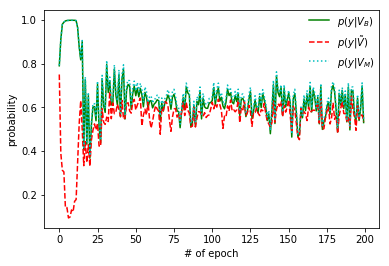

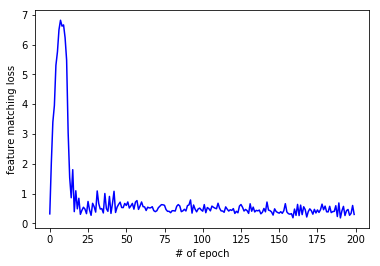

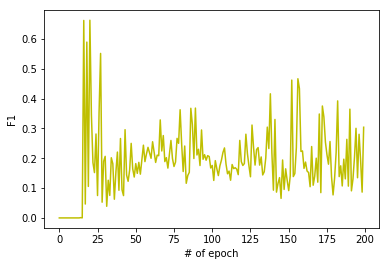

In [14]:
def draw_trend(D_real_prob, D_fake_prob, D_val_prob, fm_loss, f1):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(311)
    p1, = plt.plot(D_real_prob, "-g")
    p2, = plt.plot(D_fake_prob, "--r")
    p3, = plt.plot(D_val_prob, ":c")
    plt.xlabel("# of epoch")
    plt.ylabel("probability")
    leg = plt.legend([p1, p2, p3], [r'$p(y|V_B)$', r'$p(y|\~{V})$', r'$p(y|V_M)$'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    # plt.legend(frameon=False)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(312)
    p4, = plt.plot(fm_loss, "-b")
    plt.xlabel("# of epoch")
    plt.ylabel("feature matching loss")
    # plt.legend([p4], ["d_real_prob", "d_fake_prob", "d_val_prob"], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(313)
    p5, = plt.plot(f1, "-y")
    plt.xlabel("# of epoch")
    plt.ylabel("F1")
    # plt.legend([p1, p2, p3, p4, p5], ["d_real_prob", "d_fake_prob", "d_val_prob", "fm_loss","f1"], loc=1, bbox_to_anchor=(1, 3.5), borderaxespad=0.)
    plt.show()

    
draw_trend(d_ben_pro, d_fake_pro, d_val_pro, fm_loss_coll, f1_score)


OCAN: 
              precision    recall  f1-score   support

     genuine     0.4928    0.7361    0.5903      9430
       fraud     0.4579    0.2273    0.3038      9247

    accuracy                         0.4842     18677
   macro avg     0.4753    0.4817    0.4471     18677
weighted avg     0.4755    0.4842    0.4485     18677

Accuracy Score:  0.4841784012421695

Linear Classifier: 
              precision    recall  f1-score   support

     genuine     0.5492    0.4895    0.5176      3855
       fraud     0.5123    0.5716    0.5403      3616

    accuracy                         0.5292      7471
   macro avg     0.5307    0.5306    0.5290      7471
weighted avg     0.5313    0.5292    0.5286      7471

Accuracy Score:  0.5292464194886896


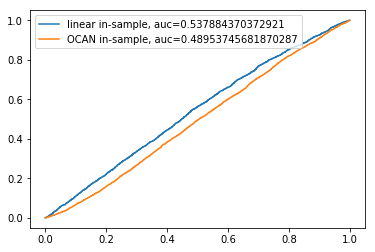

In [15]:
print ("OCAN: ")
print(conf_mat)
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))

train_x, val_x, train_y, val_y = train_test_split(x_test, y_test, test_size=0.4)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
pred_y_prob = clf.predict_proba(val_x)[:,1]

print ("")
print ("Linear Classifier: ")
print (classification_report(val_y, pred_y, target_names=['genuine', 'fraud'], digits=4))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, thresh = roc_curve(val_y, pred_y_prob)
auc = roc_auc_score(val_y, pred_y_prob)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_prob)
auc2 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.plot(fpr2,tpr2,label="OCAN in-sample, auc="+str(auc2))
plt.legend(loc='best')
plt.show()